In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import functools
from scipy.integrate import quad
from tensorflow.keras import regularizers

2024-12-09 18:03:09.267962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Function used to Calculate the Magnetic Force at a Distance x
def FM(x):
    r = 10 ** -3
    Mu = 4 * np.pi * 10 ** -7
    V = (4 / 3) * np.pi * r ** 3
    m = 2 * 10 ** -19
    kB = 1.3803288 * 10 ** -23
    Ms = 23.5 * 10 ** 3
    T = 300

    coth = lambda x: 1 / np.tanh(x)

    a5 = -(2.5573 * 10 ** 13)
    a4 = (2.5005 * 10 ** 12)
    a3 = - (9.538 * 10 ** 10)
    a2 = (1.7906 * 10 ** 9)
    a1 = - (1.699 * 10 ** 7)
    a0 = 69605.5

    Hs = a5 * x ** 5 + a4 * x ** 4 + a3 * x ** 3 + a2 * x ** 2 +a1 * x + a0
    abs_Hs = np.abs(Hs)
    coth_term = coth((Mu * m / (kB * T)) * abs_Hs)
    Mfit = Ms * (coth_term - (kB * T) / (Mu * m * abs_Hs)) * Hs / abs_Hs
    DH = 5 * a5 * x ** 4 + 4 * a4 * x ** 3 + 3 * a3 * x ** 2 + 2 * a2 * x + a1
    Fmx = -(V * Mu) * Mfit * DH

    return Fmx

# Function used to Calculate the Time towards the Target (via Numerical Integration)
def compute_time(z, r, Visc):
    time, _ = quad(lambda x: (6 * np.pi * r * Visc / FM(x)), 0, z)
    return time

In [3]:
# Define Problem Values
np.random.seed(42)
num_samples = 6
r = 10 ** -3
Visc = 50
f = functools.partial(compute_time, r=10 ** -3, Visc=50)
L=1E-3
t_noise_level = 1E3
x_noise_level = 1E-4


# Generate Training Data
x_train = np.linspace(0.015, 0.02, num_samples).reshape(-1, 1)
t_train = (np.array([f(x) for x in x_train]) + t_noise_level*np.random.normal(0, 1, num_samples)).reshape(-1, 1)

# Account for Brownian Motion
dt_train = [abs(t_train[1] - t_train[0])] + [abs(t_train[i]-t_train[i-1]) for i in range(1, len(t_train))]
x_train = np.array([x_train[i] + x_noise_level*np.random.normal(0, np.sqrt(dt_train[i]), 1) for i in range(len(x_train))]).reshape(-1, 1)

# Scale Training Data
x_train_scaled = x_train/L
t_train_scaled = (np.log(t_train)).reshape(-1, 1)

# Convert to TensorFlow Tensors
x_train_tf = tf.convert_to_tensor(x_train_scaled, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train_scaled, dtype=tf.float32)
input_train = tf.concat([x_train_tf], axis=1)

# Generate Test Data for Prediction
x_test = np.linspace(0, 0.02, 1000).reshape(-1, 1)
t_exact = (np.array([f(x) for x in x_test])).reshape(-1, 1)

# Account for Brownian Motion
dt_test = [abs(t_exact[1] - t_exact[0])] + [abs(t_exact[i]-t_exact[i-1]) for i in range(1, len(t_exact))]
x_test = np.array([x_test[i] + x_noise_level*np.random.normal(0, np.sqrt(dt_test[i]), 1) for i in range(len(x_test))]).reshape(-1, 1)

# Scale Testing Data
x_test_scaled = x_test/L

# Convert to TensorFlow Tensors
x_test_tf = tf.convert_to_tensor(x_test_scaled, dtype=tf.float32)
input_test = tf.concat([x_test_tf], axis=1)

In [4]:
# Define PINN Model
class PINN(tf.keras.Model):
    # Define PINN Architecture
    def __init__(self, neurons = 100):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(neurons, activation='gelu', input_dim=1)
        self.dense2 = tf.keras.layers.Dense(neurons, activation='gelu')
        self.dense3 = tf.keras.layers.Dense(neurons, activation='gelu')
        self.dense4 = tf.keras.layers.Dense(neurons, activation='gelu')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    # Define Feedforward Mechanism
    def call(self, inputs):
        x = inputs[:, 0:1]
        concat_input = tf.concat([x], axis=1)
        hidden1 = self.dense1(concat_input)
        hidden2 = self.dense2(hidden1)
        hidden3 = self.dense3(hidden2)
        hidden4 = self.dense4(hidden3)
        output = self.output_layer(hidden4)
        return output

In [5]:
# Function Used to Calculate Physics Loss
def physics_loss(model):
    x = np.linspace(0, 0.02, 1000).reshape(-1, 1)
    ode = 6 * np.pi * r * Visc / FM(x)
    x = x/L
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x)
        dT = tape.gradient(pred, x)
    pde_residual = ode - (np.exp(pred)/L)*dT
    return tf.reduce_mean(tf.square(pde_residual))

In [6]:
# Function Used to Train Model
def train_model(model, x_train, y_train, epochs, data_loss_weight=1e0, phys_loss_weight=1e0):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = model(input_train)
            data_loss = tf.reduce_mean(tf.square(y_pred - y_train))
            phys_loss = physics_loss(model)
            total_loss = data_loss_weight * data_loss + phys_loss_weight * phys_loss
        
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 50 == 0:
            print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.numpy()}, Physics Loss: {phys_loss.numpy()}, Data Loss: {data_loss.numpy()}")

In [7]:
# Instantiate and Train Model
model = PINN()
train_model(model, input_train, t_train_tf, 4000)

/usr/local/Caskroom/miniconda/base/envs/pinn/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0/4000, Total Loss: 116311392256.0, Physics Loss: 116311392256.0, Data Loss: 48.87858581542969
Epoch 50/4000, Total Loss: 38863269888.0, Physics Loss: 38863269888.0, Data Loss: 1.5096896886825562
Epoch 100/4000, Total Loss: 13610809344.0, Physics Loss: 13610809344.0, Data Loss: 1.4597641229629517
Epoch 150/4000, Total Loss: 11400284160.0, Physics Loss: 11400284160.0, Data Loss: 1.4026638269424438
Epoch 200/4000, Total Loss: 11170494464.0, Physics Loss: 11170494464.0, Data Loss: 1.4424031972885132
Epoch 250/4000, Total Loss: 11073162240.0, Physics Loss: 11073162240.0, Data Loss: 1.516588807106018
Epoch 300/4000, Total Loss: 11459104768.0, Physics Loss: 11459104768.0, Data Loss: 1.6807461977005005
Epoch 350/4000, Total Loss: 11986264064.0, Physics Loss: 11986264064.0, Data Loss: 1.895400881767273
Epoch 400/4000, Total Loss: 3259054336.0, Physics Loss: 3259054336.0, Data Loss: 0.4838142395019531
Epoch 450/4000, Total Loss: 1102453632.0, Physics Loss: 1102453632.0, Data Loss: 0.26923

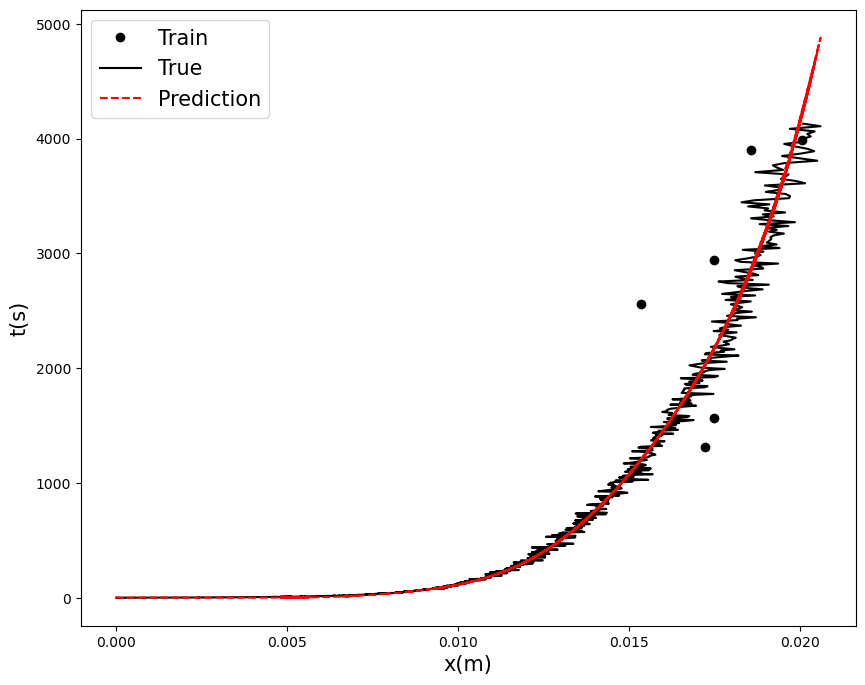

In [8]:
# Make Predictions for Entire Interval
t_pred = model(input_test)

# Plot Predictions
plt.figure(figsize = (10,8))
plt.plot(x_train, t_train, 'ok', label = 'Train')
plt.plot(x_test, t_exact, '-k',label = 'True')
plt.plot(x_test, np.exp(t_pred), '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('x(m)', fontsize = 15)
plt.ylabel('t(s)', fontsize = 15)
plt.show()